
## Setting up

In [2]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT)   

Mounted at /content/drive


In [3]:
import os
rootPath = '/content/drive/My Drive/Detecting_Oil_Gas_Infrastructure'
os.chdir(rootPath)

## Installing & Importing Packages

In [ ]:
!pip uninstall -y shapely;

In [ ]:
!pip install git+git://github.com/toblerity/shapely.git

In [ ]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes

In [9]:
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os

## Connect to GEE API
Get Sentinel & naip imagery


In [ ]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

In [11]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


## Read in VIIRS AF Product

In [12]:
viirs_noaa_19_20_gpd = gpd.read_file('data/VIIRS_NOAA/DL_FIRE_J1V-C2_204590/fire_nrt_J1V-C2_204590.shp')

## Clip to extent

In [15]:
permian_basin = gpd.read_file('data/PermianBasin_Extent_201712/PermianBasin_Extent_201712.shp')

In [ ]:
if permian_basin.crs == viirs_noaa_19_20.crs:
  print('true')

true


In [ ]:
# clip to extent 
permian_viirs_19_20_gpd = gpd.clip(viirs_noaa_19_20, permian_basin)
permian_viirs_19_20_gpd.plot()

In [ ]:
permian_viirs_19_20_gpd.head(3)

In [ ]:
# permian_viirs_19_20.to_file("data/VIIRS_NOAA/permian_viirs_19_20/permian_viirs_19_20.geojson", driver='GeoJSON')
permian_viirs_19_20_gpd.to_file("data/VIIRS_NOAA/permian_viirs_19_20/permian_viirs_19_20.shp")

## Connect to EarthData 

Upload from cloud bucket as GEE asset

In [ ]:
# upload viirs 2020--present
! earthengine upload table --asset_id=users/escaduto/oil_gas_detection/permian_viirs_noaa_19_20 gs://oil_gas_detection/permian_viirs_19_20/permian_viirs_19_20.shp

In [ ]:
# upload permian bounds 
! earthengine upload table --asset_id=users/escaduto/oil_gas_detection/permian_bounds gs://oil_gas_detection/permian_bounds/PermianBasin_Extent_201712.shp

## Get High Resolution imagery via GEE APi

In [13]:
def extract_coords(geom):
    '''
    takes one polygon from geopandas and converts it to the GEE geometry format
    input: geom from each row of the 'geometry' column in the gpd dataframe 
    output: coordinate list of the GEE geometry
    '''
    try:
        coords=geom.__geo_interface__['coordinates']
        geom_extr=[list(map(list,coord)) for coord in coords]
        return geom_extr
    except:
        pass

def get_bounds(gdf):
    '''
    takes a geo data frame get convert its bounding extent to a GEE format rectangle
    '''
    bounds=gdf.total_bounds
    geom_bound=[[ [bounds[0],bounds[1]], [bounds[2],bounds[1]], [bounds[2],bounds[3]], [bounds[0],bounds[3]]]]
    return geom_bound

In [16]:
# extract_coords(geom)
permian_coord = extract_coords(permian_basin['geometry'].iloc[0])
permian_bounds = get_bounds(permian_basin)

In [17]:
startYr = '2018'
startMth = '01'
startDy = '01'

endYr = '2021'
endMth = '06'
endDy = '13'

Bound_Box = ee.Geometry.Polygon(permian_bounds)
permian_geometry = ee.Geometry.Polygon(permian_coord)

### NAIP

In [18]:
 def getNAIP(startDate, endDate):
  recent_NAIP = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                      .filter(ee.Filter.date(startDate, endDate))
                      .select(['R', 'G', 'B', 'N'])
                      .filterBounds(Bound_Box)
                      .mosaic());

  recent_NAIP = recent_NAIP.clip(permian_geometry)
  return recent_NAIP

recent_NAIP = getNAIP(f'{startYr}-{startMth}-{startDy}', f'{endYr}-{endMth}-{endDy}')

### Sentinel2

In [19]:
 def getSentinel(startDate, endDate):
  recent_Sentinel= ee.Image(ee.ImageCollection('COPERNICUS/S2')
                    .filter(ee.Filter.date(startDate, endDate))
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                    .filterBounds(Bound_Box)
                    .mosaic())
                    

  recent_Sentinel = recent_Sentinel.clip(permian_geometry)
  return recent_Sentinel

recent_Sentinel = getSentinel('2021-05-01', f'{endYr}-{endMth}-{endDy}')
rgbVis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 5000, 'gamma': 1.1}

### TROPOMI

In [100]:
def getTROPOMi(startDate, endDate):
  tropomi = ee.Image(ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')
              .select('CH4_column_volume_mixing_ratio_dry_air')
              .filterDate(startDate, endDate)
              .filterBounds(Bound_Box)
              .mean())

  tropomi = tropomi.clip(permian_geometry)
  return tropomi

tropomi = getTROPOMi('2021-05-01', f'{endYr}-{endMth}-{endDy}')

band_viz = {
  'min': 1890,
  'max': 1910,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red'],
  'opacity': 0.5
}

## Clustering

ee.weka kmeans 

dbscan

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 0.005 # 100m

coords = permian_viirs_19_20_gpd[['LONGITUDE', 'LATITUDE']].values
db = (DBSCAN(eps=epsilon, min_samples=5, algorithm='auto', metric = 'euclidean').fit(coords))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
n_clusters_

766

In [ ]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = coords[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = coords[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
xy = coords[class_member_mask & core_samples_mask]

In [ ]:
clusters = [coords[labels == i] for i in range(0, n_clusters_)]

In [ ]:
outliers = coords[labels == -1]
outliers

array([[-103.85481,   31.84687],
       [-102.7403 ,   33.71899],
       [-103.94793,   31.73957],
       ...,
       [-104.2264 ,   31.87992],
       [-101.99758,   31.59547],
       [-102.39597,   31.44758]])

In [ ]:
cluster_id = []
longitude = [] 
latitude = [] 

for i, array_i in enumerate(clusters):
  for pt in array_i: 
    lon = pt[0]
    lat = pt[1]

    longitude.append(lon)
    latitude.append(lat)
    cluster_id.append(i)

In [ ]:
import pandas as pd
df = pd.DataFrame({'cluster_id': cluster_id, 'Longitude': longitude, 'Latitude': latitude})

cluster_results = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [ ]:
len(cluster_results['cluster_id'].unique())

766

In [ ]:
ep = '005'
cluster_results.to_file(f"results/dbscan/viirs_cluster_dbscan_{ep}.geojson", driver='GeoJSON')

In [ ]:
import geemap
geojson_file_path = f"results/dbscan/viirs_cluster_dbscan_{ep}.geojson"
ee_object = geemap.geojson_to_ee(geojson_file_path)

task = ee.batch.Export.table.toAsset(
    collection = ee_object,
    description = f'viirs_cluster_dbscan_{ep}',
    assetId = f'users/escaduto/oil_gas_detection/viirs_cluster_dbscan_{ep}'
)

task.start()

## Centroid of clusters

In [ ]:
cluster_centroid = cluster_results.dissolve(by='cluster_id')

In [ ]:
s = gpd.GeoSeries(cluster_centroid.centroid)

cluster_centroid['Longitude'] = s.apply(lambda p: p.x)
cluster_centroid['Latitude'] = s.apply(lambda p: p.y)

cluster_centroid = gpd.GeoDataFrame(
    cluster_centroid, geometry=gpd.points_from_xy(cluster_centroid.Longitude, cluster_centroid.Latitude))


In [ ]:
cluster_centroid.reset_index(drop=True, inplace=True)
cluster_centroid[['geometry']]

In [ ]:
cluster_centroid.to_file(f"results/dbscan/viirs_centroids_dbscan_{ep}.geojson", driver='GeoJSON')

In [ ]:
import geemap
geojson_file_path = f"results/dbscan/viirs_centroids_dbscan_{ep}.geojson"
ee_object = geemap.geojson_to_ee(geojson_file_path)

task = ee.batch.Export.table.toAsset(
    collection = ee_object,
    description = f'viirs_centroids_dbscan_{ep}',
    assetId = f'users/escaduto/oil_gas_detection/viirs_centroids_dbscan_{ep}'
)

task.start()

## Visualize output

In [26]:
ep = '005'
cluster_results_1 = ee.FeatureCollection(f'users/escaduto/oil_gas_detection/viirs_cluster_dbscan_{ep}')
cluster_centroid = ee.FeatureCollection(f'users/escaduto/oil_gas_detection/viirs_centroids_dbscan_005')
permian_viirs_noaa_19_20 = ee.FeatureCollection(f'users/escaduto/oil_gas_detection/permian_viirs_noaa_19_20')


Map = emap.Map(center=[32.017080826441465, -103.13585525947516], zoom=7)
Map.add_basemap('TERRAIN')
Map.addLayer(recent_NAIP.select(['R', 'G', 'B']), '', 'recent_NAIP')
Map.addLayer(recent_Sentinel, rgbVis, 'recent_Sentinel')
Map.addLayer(tropomi, band_viz, 'S5P CH4')
Map.addLayer(permian_viirs_noaa_19_20, '', 'permian_viirs_noaa_19_20')
Map.addLayer(cluster_results_1, '', 'cluster_results_1')
Map.addLayer(cluster_centroid, {'color': 'FF0000'}, 'cluster_centroid')
Map.addLayerControl()
Map

## Add attributes to points

Spatial join cluster results with viirs original data layer. 

COLUMNS: 
Cluster_ID, LATITUDE, LONGITUDE, BRIGHTNESS, ACQ_DATE, ACQ_TIME, FRP, geometry

In [27]:
cluster_centroid = gpd.read_file(f"results/dbscan/viirs_centroids_dbscan_{ep}.geojson")
cluster_results = gpd.read_file(f"results/dbscan/viirs_cluster_dbscan_{ep}.geojson")
permian_viirs_19_20_gpd = gpd.read_file("data/VIIRS_NOAA/permian_viirs_19_20/permian_viirs_19_20.geojson")

In [28]:
cluster_results = cluster_results.set_crs(permian_viirs_19_20_gpd.crs)

In [ ]:
col = ['BRIGHTNESS', 'BRIGHT_T31', 'ACQ_DATE', 'ACQ_TIME', 'FRP', 'geometry']

cluster_results_full = gpd.sjoin(cluster_results, permian_viirs_19_20_gpd[col], how="left").drop(columns=['index_right'])
cluster_results_full

In [30]:
# add month , day columns 
cluster_results_full.dtypes

cluster_results_full.head(3)

,cluster_id,Longitude,Latitude,geometry,BRIGHTNESS,BRIGHT_T31,ACQ_DATE,ACQ_TIME,FRP
0,0,-101.79024,32.47284,POINT (-101.79024 32.47284),298.7,274.5,2020-01-01,0818,0.8
1,0,-101.78951,32.47195,POINT (-101.78951 32.47195),305.0,276.4,2020-01-05,0842,0.7
2,0,-101.78985,32.47275,POINT (-101.78985 32.47275),320.2,275.0,2020-01-06,0824,1.2


In [31]:
import pandas as pd
cluster_results_full["ACQ_DATE"] = pd.to_datetime(cluster_results_full["ACQ_DATE"], format='%Y-%m-%d')
cluster_results_full.dtypes

cluster_id             int64
Longitude            float64
Latitude             float64
geometry            geometry
BRIGHTNESS           float64
BRIGHT_T31           float64
ACQ_DATE      datetime64[ns]
ACQ_TIME              object
FRP                  float64
dtype: object

## Plot Timeseries VIIRS Detection by ClusterID


In [32]:
# grouped_sample = sample.groupby('ACQ_DATE')['cluster_id'].count().reset_index()
import seaborn as sns

def groupby_date(df):
  groupby_day = df.groupby(pd.PeriodIndex(data=df.ACQ_DATE, freq='D'))
  grouped_sample = groupby_day['cluster_id'].count().reset_index()
  return grouped_sample

def createTimeseries(df, plot_title):
  grouped_sample = groupby_date(df)
  idx = pd.period_range(min(cluster_results_full.ACQ_DATE), max(cluster_results_full.ACQ_DATE))
  grouped_sample.columns = ['ACQ_DATE', 'Frequency']
  grouped_sample = grouped_sample.set_index("ACQ_DATE")
  grouped_sample = grouped_sample.reindex(idx, fill_value=0).sort_index()
  
  
  grouped_sample.plot()
  # ax1 = sns.lineplot(data = grouped_sample, markers=True, legend=False, palette='Reds_r', linewidth = 2)
  plt.title(plot_title)
  plt.xlabel("Detection Date")
  plt.ylabel("Frequency")
  return plt

In [33]:
def plot_by_clusterid(cluster_id, plot_title):
  df = cluster_results_full[cluster_results_full['cluster_id'] == cluster_id]
  return createTimeseries(df, plot_title)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

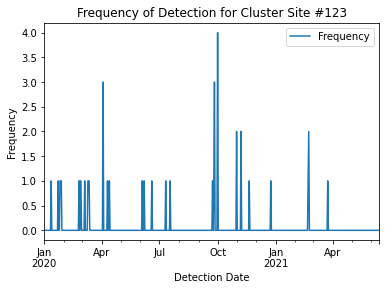

In [34]:
plot_by_clusterid(123, plot_title = f"Frequency of Detection for Cluster Site #{123}")

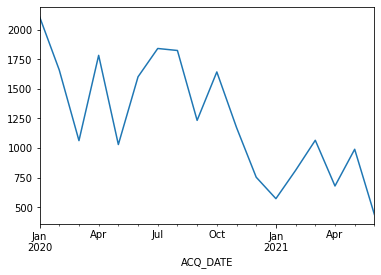

In [42]:
# cluster_results_full.resample("M").mean()
groupby_month = cluster_results_full.set_index("ACQ_DATE")['cluster_id'].resample("M").count()
groupby_month.plot()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

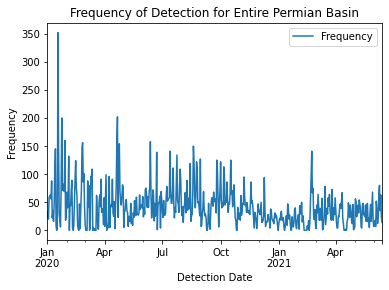

In [35]:
createTimeseries(cluster_results_full, plot_title = f"Frequency of Detection for Entire Permian Basin")

## Create interactive map 

Displays all clustered active sites based on viirs-noaa AF. 
Interactive >> **click to see timeseries of detection frequencies for specific site.**

* start day - end days 
* num of total detected 
* num of total active days i.e. unique days 
* average FRP 


Overlay naip and sentinel imagery

In [46]:
import ipywidgets as widgets 
from ipywidgets import AppLayout, Button, Layout, Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, DatePicker, Output, VBox, HBox, Text, SelectMultiple, Combobox, Accordion
from ipywidgets.embed import embed_data
from IPython.display import clear_output, HTML, display, Image

In [256]:
from datetime import datetime, timedelta
from datetime import date, timedelta
from dateutil.relativedelta import *

map_output = widgets.Output(layout=Layout(width='80%', height='50%'))

dates = [date(2020, 1, 1) + relativedelta(months=+x) for x in range(18)]
dates_str = [date_obj.strftime('%b %Y') for date_obj in dates]

date_slider = widgets.SelectionSlider(
    options= dates_str,
    description='Select by Month',
    style=dict(description_width='initial'),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True)

def getStartEndDate(dateValue):   
    datetime_object = datetime.strptime(date_slider.value, '%b %Y')
    selected_yr = datetime_object.year
    selected_month = datetime_object.month

    startDate = f'{selected_yr}-{selected_month}-01'
    endDate = f'{selected_yr}-{selected_month}-28'
    return startDate, endDate


def createMap(dateValue, mapCenter, mapZoom):
  startDate, endDate = getStartEndDate(dateValue)
  cluster_results_dbscan = ee.FeatureCollection(f'users/escaduto/oil_gas_detection/viirs_cluster_dbscan_005')
  cluster_centroid = ee.FeatureCollection(f'users/escaduto/oil_gas_detection/viirs_centroids_dbscan_005')
  recent_NAIP = getNAIP(f'2018-01-01', f'2021-06-13')
  recent_Sentinel = getSentinel(startDate, endDate)
  tropomi = getTROPOMi(startDate, endDate)
  Map = emap.Map(center= mapCenter, zoom= mapZoom)
  Map.add_basemap('TERRAIN')
  Map.addLayer(recent_NAIP.select(['R', 'G', 'B']), '', 'recent_NAIP')
  Map.addLayer(recent_Sentinel, rgbVis, 'recent_Sentinel')
  Map.addLayer(tropomi, band_viz, 'Tropomi CH4', False)
  Map.addLayer(permian_viirs_noaa_19_20, {'color': 'fae878', 'opacity':0.5}, 'permian_viirs_noaa_19_20')
  Map.addLayer(cluster_results_dbscan, {'color': 'a5ea8b', 'opacity':0.8}, 'cluster_results_dbscan')
  Map.addLayer(cluster_centroid, {'color': 'FF0000'}, 'cluster_centroid')
  Map.addLayerControl()

  return Map


latitude_input =  widgets.FloatText(
    description='Latitude:',
    value = 31.8004,
    disabled=False
)

longitude_input =  widgets.FloatText(
    description='Longitude:',
    disabled=False,
    value = -102.0982

)

zoom_int = widgets.IntText(
    value=13,
    description='Zoom:',
    disabled=False
)


def on_value_change(change):
  with map_output: 
    clear_output()
    mapCenter = [latitude_input.value, longitude_input.value]
    mapZoom = zoom_int.value
    Map = createMap(date_slider.value, mapCenter, mapZoom)
    display(Map)


date_slider.observe(on_value_change, names='value')

In [257]:
layer_selection = widgets.SelectMultiple(
    options=['VIIRS (375m)', 'O&G cluster (VIIRS)', 'TROPOMI', 'Sentinel (10m)', 'NAIP (1m)'],
    description='Layers',
    disabled=False)

In [264]:
tab_header = widgets.HTML(value='<b style="font-size:20px">Visualizing O&G Infrasture Data Layers in the Permian Basin</b>')
description = widgets.HTML(value= '<p style="font-size:14px"><b>Instruction:</b> This interactive mapping tool allows users to visualize \
              oil & gas infrastructure related data layers from January 2020 until June 2021.\
              Select by month-year to display data layers including: (1) VIIRS hot spot detection, (2) \
              cluster centroid, (3) Sentinel (monthly; 10-m), (4) NAIP (2018; 1-m), and (5) Tropomi (monthly; avg). Map center coordinates: Latitude and Longitude \
              values can be entered. Click on any location of the map to display coordinates for reference. \
              Select Map Zoom extent for additional control over display.</p>')
tab1 = VBox(children=[tab_header,description, date_slider, HBox(children=[latitude_input, longitude_input]), zoom_int, map_output])

## Final Widget

In [265]:
tab_nest = widgets.Tab()
tab_nest.children = [tab1]
tab_nest.set_title(0, 'O&G Sites')
tab_nest